# Solar cell at different incident angles

The goal of this notebook is to check the CBP transmission when the solar cell is used at different incident angles, not too far from the normal incidence.

In [2]:
import os, sys
print(os.path.dirname(os.getcwd()))
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits

from astropy import constants as const
from astropy import units as u
from scipy.interpolate import interp1d


from solarcell_dataset import SolarCellDataSet, SolarCellRun, calculate_npulses, get_info_from_filename, estimate_noise, get_solarcell_total_charge
%matplotlib notebook

/home/jneveu/stardice/analysis/cbp_paper


Run at normal indicence :

In [3]:
datapath="/data/STARDICE/cbp/solarcell/ut20210719/"
other_str="Angle_0"
nbursts = 5

run = SolarCellRun(directory_path=datapath, nbursts=nbursts, tag=other_str)
run.load()
run.load_from_file(os.path.join(datapath, f"QSWMax_EMPTY_Angle_0_ntuple.npy"))

100%|██████████| 140/140 [00:12<00:00, 10.98it/s]


Run at a negative low incident angle : the solar cell is inclined a little bit.

In [4]:
datapath="/data/STARDICE/cbp/solarcell/ut20210719/"
other_str="Angle_Bas"
nbursts = 5

run_low = SolarCellRun(directory_path=datapath, nbursts=nbursts, tag=other_str)
run_low.load()
run_low.load_from_file(os.path.join(datapath, f"QSWMax_EMPTY_Angle_Bas_ntuple.npy"))

100%|██████████| 140/140 [00:12<00:00, 11.31it/s]


Run at a positive low incident angle : the solar cell is inclined a little bit.

In [5]:
datapath="/data/STARDICE/cbp/solarcell/ut20210719/"
other_str="Angle_Haut"
nbursts = 5

run_high = SolarCellRun(directory_path=datapath, nbursts=nbursts, tag=other_str)
run_high.load()
run_high.load_from_file(os.path.join(datapath, f"QSWMax_EMPTY_Angle_Haut_ntuple.npy"))

100%|██████████| 140/140 [00:11<00:00, 11.71it/s]


<IPython.core.display.Javascript object>


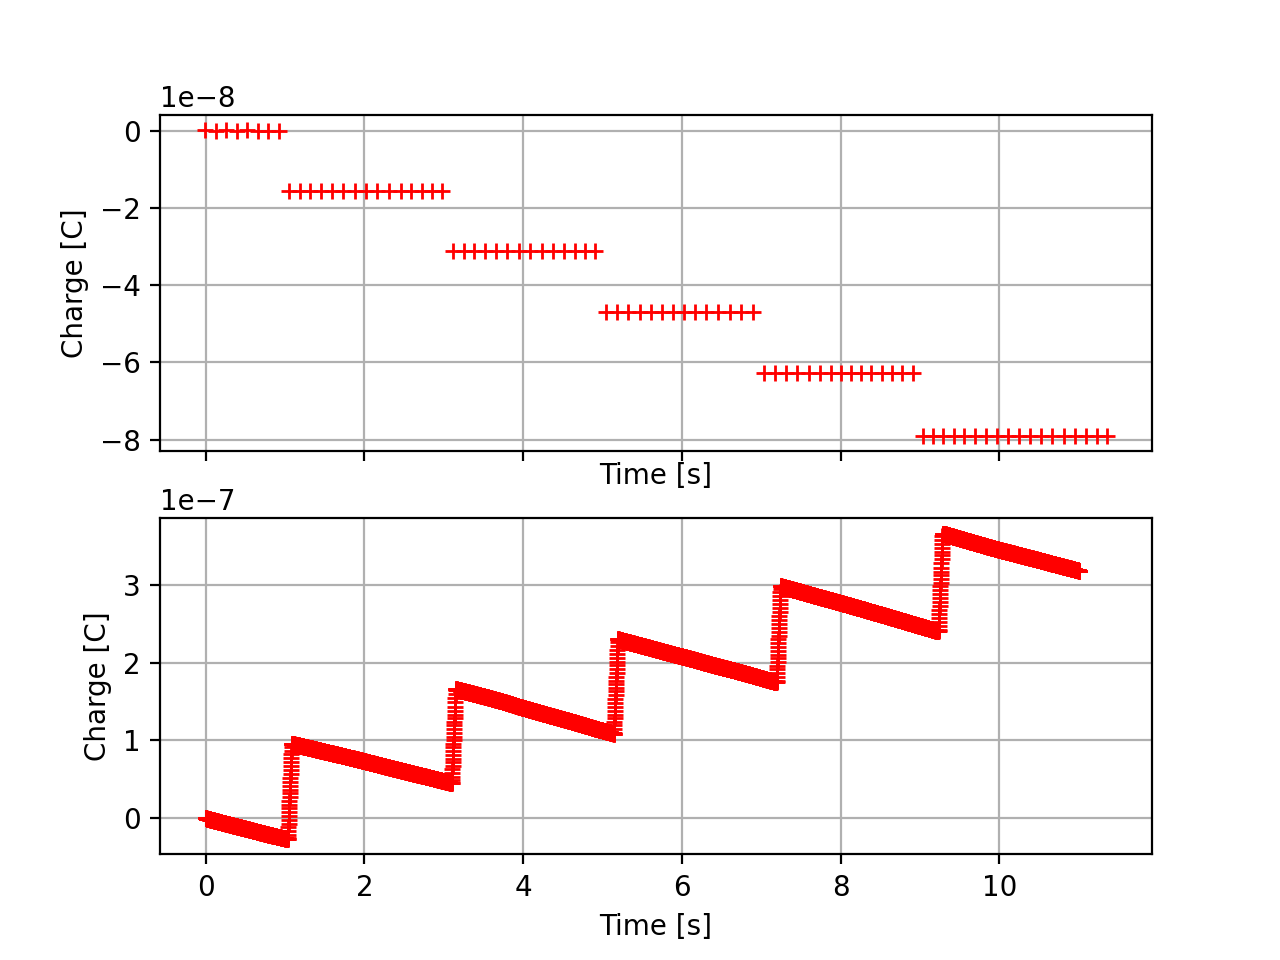

In [6]:
d = run.get_data_set(1045, 5)
d.plot_data_set()

### CBP transmissions at different angles

In [28]:
ref_data_root = "/data/STARDICE/cbp/solarcell/refCalData/"
SC_QE_data_file = ref_data_root + 'SC_QE_from_mono_SC_ED_20210618_MultiDay.txt'
PD_QE_data_file = ref_data_root + 'SM05PD1B_QE.csv'

SC_QE = np.loadtxt(SC_QE_data_file, skiprows=1, delimiter=",").T
PD_QE = np.loadtxt(PD_QE_data_file, skiprows=1, delimiter=",").T

# PD_QE is in A/W units, convert it to e-/photons as SC_QE
PD_QE[1] *= (const.h * const.c / (PD_QE[0] * 1e-9 * u.meter * const.e.value)).value

SC_QE_f = interp1d(SC_QE[0], SC_QE[1], bounds_error=False, fill_value=np.min(SC_QE[1]))
PD_QE_f = interp1d(PD_QE[0], PD_QE[1], bounds_error=False, fill_value=np.min(PD_QE[1]))


<IPython.core.display.Javascript object>


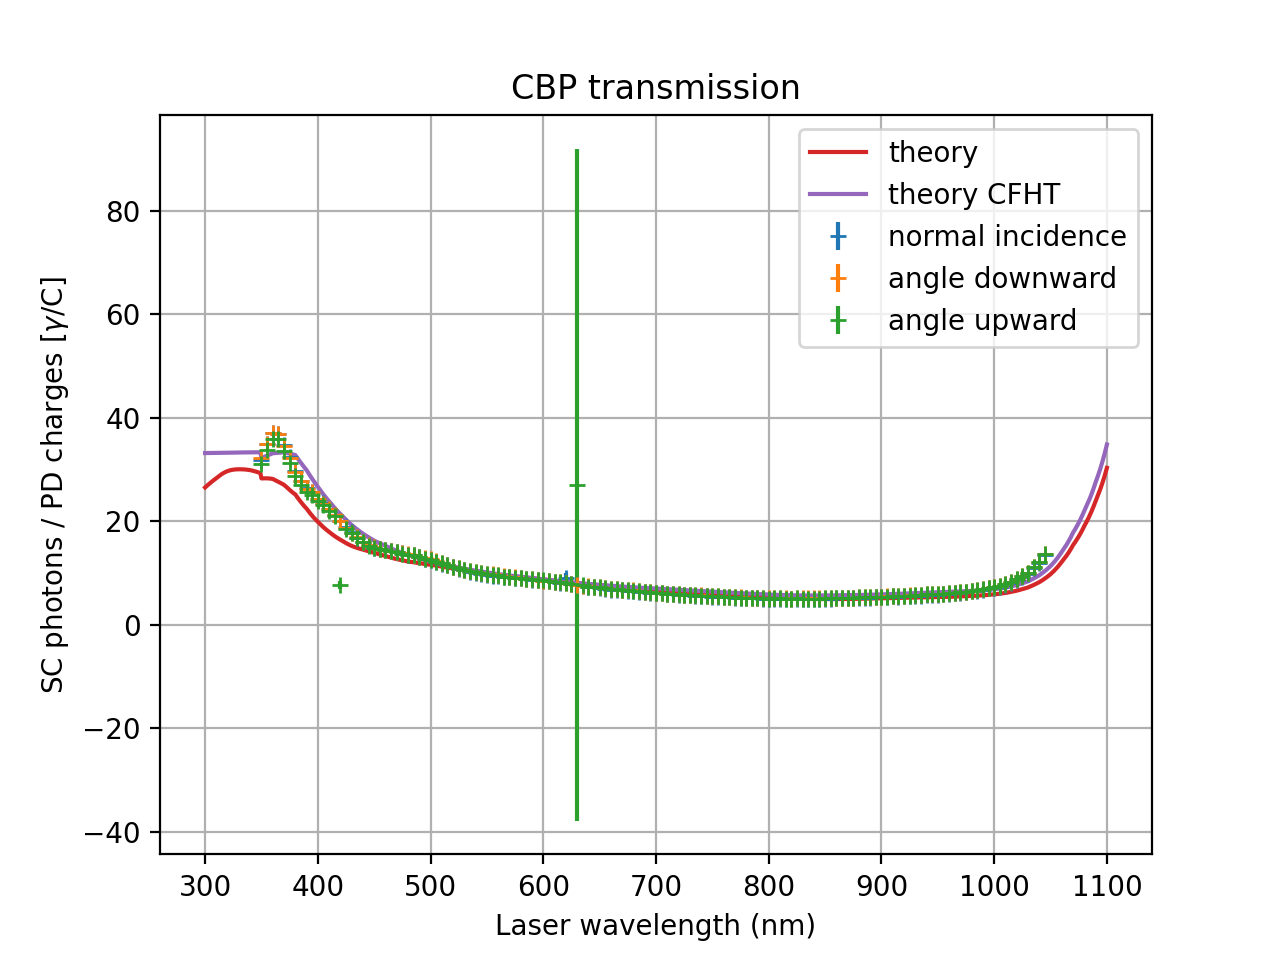

In [29]:
tr = (run.data["sc_charge_total"] / SC_QE_f(run.data["set_wl"])) /  (-run.data["pd_charge_total"]) # / np.interp(run.data["set_wl"], PD_QE[0], PD_QE[1]))
tr_err = tr * np.sqrt((run.data["sc_charge_total_err"]/run.data["sc_charge_total"])**2 + (run.data["pd_charge_total_err"]/run.data["pd_charge_total"])**2)

tr_low = (run_low.data["sc_charge_total"] / SC_QE_f(run_low.data["set_wl"])) /  (-run_low.data["pd_charge_total"]) # / np.interp(run.data["set_wl"], PD_QE[0], PD_QE[1]))
tr_low_err = tr_low * np.sqrt((run_low.data["sc_charge_total_err"]/run_low.data["sc_charge_total"])**2 + (run_low.data["pd_charge_total_err"]/run_low.data["pd_charge_total"])**2)

tr_high = (run_high.data["sc_charge_total"] / SC_QE_f(run_high.data["set_wl"])) /  (-run_high.data["pd_charge_total"]) # / np.interp(run.data["set_wl"], PD_QE[0], PD_QE[1]))
tr_high_err = tr_high * np.sqrt((run_high.data["sc_charge_total_err"]/run_high.data["sc_charge_total"])**2 + (run_high.data["pd_charge_total_err"]/run_high.data["pd_charge_total"])**2)

double_Al_wavelength, double_Al_responsivity = np.loadtxt(os.path.join(ref_data_root, 'TwoBounceAl.dat'), delimiter=',', skiprows=1).T
Al_wl, Al_CFHT = np.loadtxt(os.path.join(ref_data_root, 'CFHT_Primary_Transmission.dat'), delimiter=' ', skiprows=0).T
Al_wl *= 0.1
Al_CFHT *= Al_CFHT

fig = plt.figure()
plt.errorbar(run.data["set_wl"], tr, yerr=tr_err, marker='+', linestyle="none", label="normal incidence")
plt.errorbar(run_low.data["set_wl"], tr_low, yerr=tr_low_err, marker='+', linestyle="none", label="angle downward")
plt.errorbar(run_high.data["set_wl"], tr_high, yerr=tr_high_err, marker='+', linestyle="none", label="angle upward")
plt.plot(double_Al_wavelength, 6*double_Al_responsivity / PD_QE_f(double_Al_wavelength), '-', label="theory")
plt.plot(Al_wl, 6*Al_CFHT / PD_QE_f(Al_wl), '-', label="theory CFHT")
plt.xlabel('Laser wavelength (nm)')
plt.ylabel('SC photons / PD charges [$\gamma$/C]')
plt.grid()
plt.title("CBP transmission")
plt.legend()
plt.show()



<IPython.core.display.Javascript object>


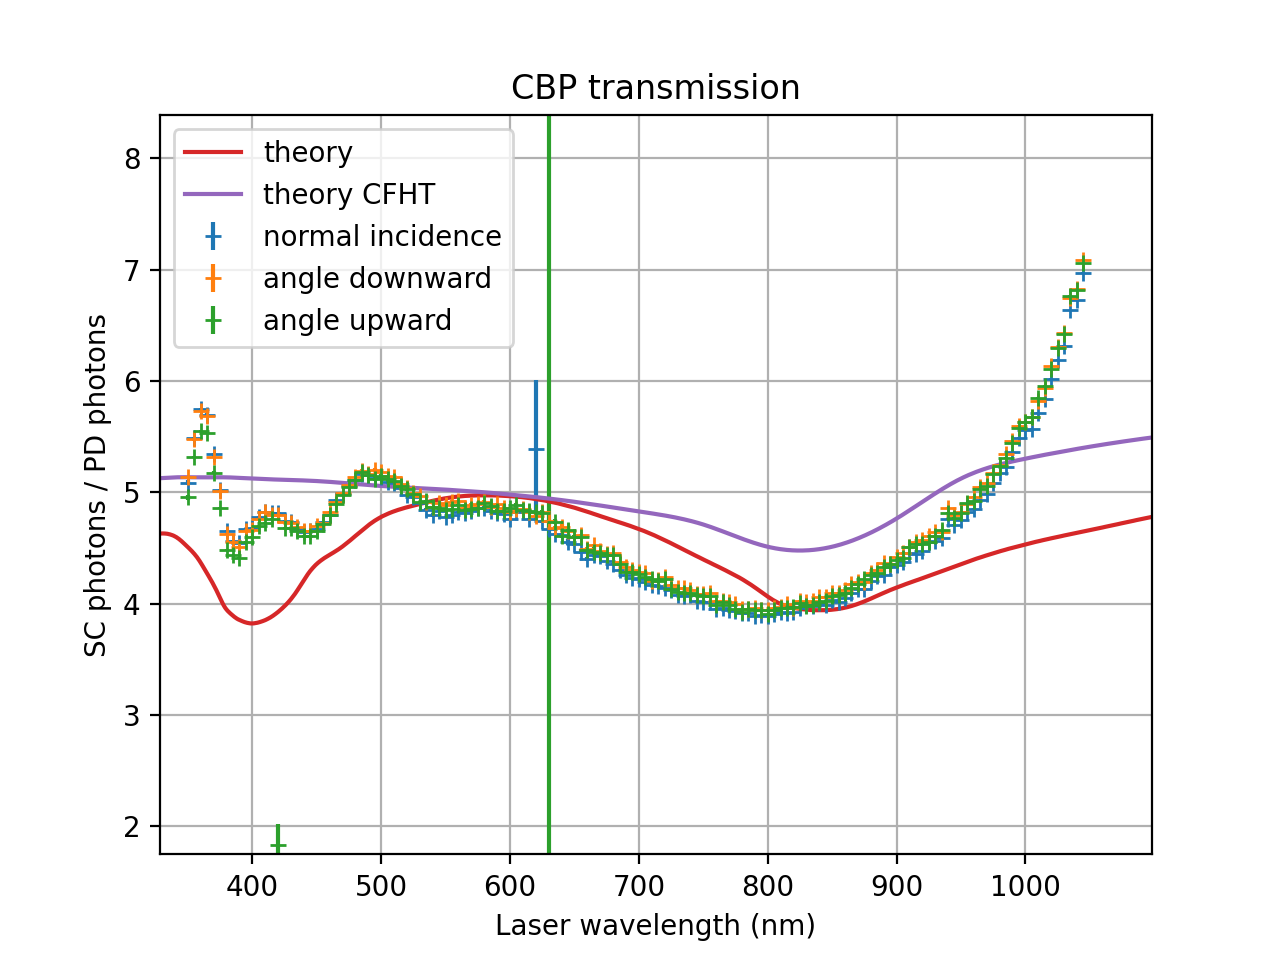

In [30]:
tr = (run.data["sc_charge_total"] / SC_QE_f(run.data["set_wl"])) /  (-run.data["pd_charge_total"] / PD_QE_f(run.data["set_wl"]))
tr_err = tr * np.sqrt((run.data["sc_charge_total_err"]/run.data["sc_charge_total"])**2 + (run.data["pd_charge_total_err"]/run.data["pd_charge_total"])**2)

tr_low = (run_low.data["sc_charge_total"] / SC_QE_f(run_low.data["set_wl"])) /  (-run_low.data["pd_charge_total"] / PD_QE_f(run_low.data["set_wl"]))
tr_low_err = tr_low * np.sqrt((run_low.data["sc_charge_total_err"]/run_low.data["sc_charge_total"])**2 + (run_low.data["pd_charge_total_err"]/run_low.data["pd_charge_total"])**2)

tr_high = (run_high.data["sc_charge_total"] / SC_QE_f(run_high.data["set_wl"])) /  (-run_high.data["pd_charge_total"] / PD_QE_f(run_high.data["set_wl"]))
tr_high_err = tr_high * np.sqrt((run_high.data["sc_charge_total_err"]/run_high.data["sc_charge_total"])**2 + (run_high.data["pd_charge_total_err"]/run_high.data["pd_charge_total"])**2)

fig = plt.figure()
plt.errorbar(run.data["set_wl"], tr, yerr=tr_err, marker='+', linestyle="none", label="normal incidence")
plt.errorbar(run_low.data["set_wl"], tr_low, yerr=tr_low_err, marker='+', linestyle="none", label="angle downward")
plt.errorbar(run_high.data["set_wl"], tr_high, yerr=tr_high_err, marker='+', linestyle="none", label="angle upward")
plt.plot(double_Al_wavelength, 6*double_Al_responsivity, '-', label="theory")
plt.plot(Al_wl, 6*Al_CFHT, '-', label="theory CFHT")
plt.xlabel('Laser wavelength (nm)')
plt.ylabel('SC photons / PD photons')
plt.title("CBP transmission")
plt.grid()
plt.legend()
plt.show()


<IPython.core.display.Javascript object>


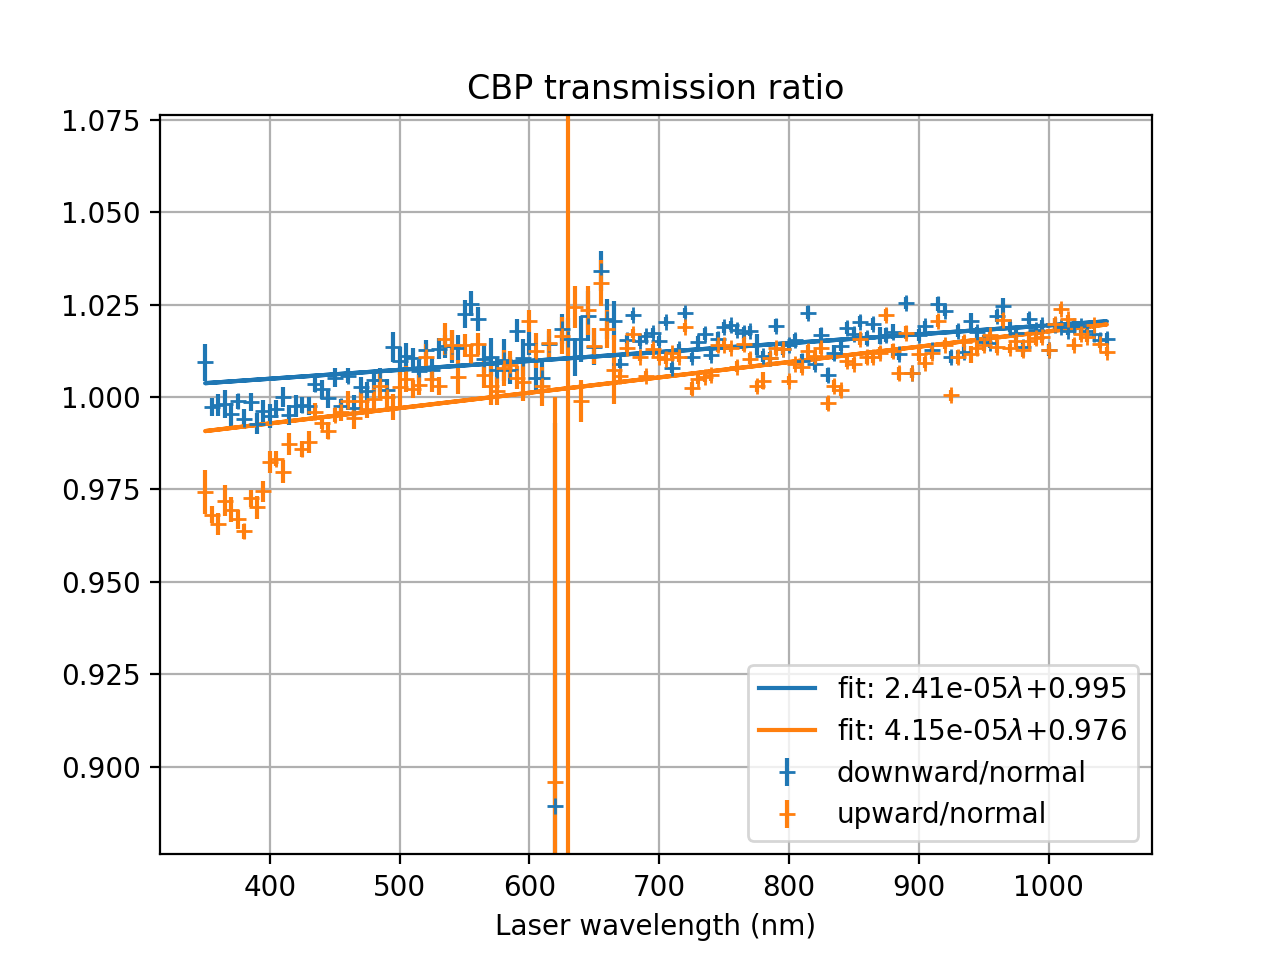

In [33]:
ratio_low = tr_low/tr
ratio_low_err = ratio_low * np.sqrt( (tr_err/tr)**2 + (tr_low_err/tr_low)**2)
w = 1/ratio_low_err
w[np.isnan(w)] = 0
pval_low = np.polyfit(run_low.data["set_wl"], ratio_low, deg=1, w=w)

ratio_high = tr_high/tr
ratio_high_err = ratio_high * np.sqrt( (tr_err/tr)**2 + (tr_high_err/tr_high)**2)
w = 1/ratio_high_err
w[np.isnan(w)] = 0
pval_high = np.polyfit(run_high.data["set_wl"], ratio_high, deg=1, w=w)

fig = plt.figure()
p = plt.errorbar(run_low.data["set_wl"], ratio_low, yerr = ratio_low_err, linestyle="none", marker="+", label="downward/normal")
plt.plot(run_low.data["set_wl"], np.polyval(pval_low, run_low.data["set_wl"]), label=f"fit: {pval_low[0]:.3g}$\lambda$+{pval_low[1]:.3f}", color=p[0].get_color())
p = plt.errorbar(run_high.data["set_wl"], ratio_high, yerr = ratio_high_err, linestyle="none", marker="+", label="upward/normal")
plt.plot(run_high.data["set_wl"], np.polyval(pval_high, run_high.data["set_wl"]), label=f"fit: {pval_high[0]:.3g}$\lambda$+{pval_high[1]:.3f}", color=p[0].get_color())
plt.title("CBP transmission ratio")
plt.grid()
plt.xlabel('Laser wavelength (nm)')
plt.legend()
plt.ylim(pval_high[1]-0.1, pval_high[1]+0.1)
plt.show()